> NOTE: Download https://www.kaggle.com/datasets/vbookshelf/respiratory-sound-database database before running this notebook.

# Importing Libraries

In [1]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

2024-05-09 16:38:19.770857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 16:38:19.770968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 16:38:19.887664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Dataset

In [2]:
df_no_diagnosis = pd.read_csv('../input/respiratory-sound-database/demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'], delimiter = ' ')

diagnosis = pd.read_csv('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [3]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

Diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: count, dtype: int64

In [4]:
root = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [5]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [6]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.tail()

Patient number Recording index Chest location Acquisition mode  \
0            200             2p4             Pr               mc   
0            156             8b3             Ll               mc   
0            162             2b3             Ar               mc   
0            162             2b4             Pr               mc   
0            200             2p3             Ar               mc   

  Recording equipment  
0            AKGC417L  
0            AKGC417L  
0            AKGC417L  
0            AKGC417L  
0            AKGC417L

In [7]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [8]:
file_label_df = pd.DataFrame(data = {'filename':filename_list})
file_label_df

filename
0    168_1b1_Al_sc_Meditron
1    172_1b4_Ar_mc_AKGC417L
2    130_3p2_Pr_mc_AKGC417L
3    177_2b4_Pl_mc_AKGC417L
4    130_2p5_Pl_mc_AKGC417L
..                      ...
915  200_2p4_Pr_mc_AKGC417L
916  156_8b3_Ll_mc_AKGC417L
917  162_2b3_Ar_mc_AKGC417L
918  162_2b4_Pr_mc_AKGC417L
919  200_2p3_Ar_mc_AKGC417L

[920 rows x 1 columns]

In [9]:
audio_path = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

In [10]:
# adding columns in file_label_df
diagnosis = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []
sample_rate = []
duration = []

for i in tqdm(range(len(file_label_df['filename']))):
  info = file_label_df['filename'][i].split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info
  #sound_filename = audio_path + file_label_df['filename'][i] + '.wav'
  #x, sr = librosa.load(sound_filename)
  #dur = round(x.shape[0]/sr, 2)
  #sample_rate.append(sr)
  #duration.append(dur)

  diagnosis.append(df['Diagnosis'][int(patient_id) - 101])
  patient_number.append(patient_id)
  recording_index.append(recording_idx)
  chest_location.append(chest_loc)
  acquisition_mode.append(acq_mode)
  recording_equipment.append(equipment)

file_label_df['Diagnosis'] = diagnosis
file_label_df['Patient Number'] = patient_number
file_label_df['Chest Location'] = chest_location
file_label_df['Acquisition Mode'] = acquisition_mode
file_label_df['Recording Equipment'] = recording_equipment
#file_label_df['duration'] = duration
#file_label_df['sample rate'] = sample_rate

  0%|          | 0/920 [00:00<?, ?it/s]

In [11]:
file_label_df

filename       Diagnosis Patient Number Chest Location  \
0    168_1b1_Al_sc_Meditron  Bronchiectasis            168             Al   
1    172_1b4_Ar_mc_AKGC417L            COPD            172             Ar   
2    130_3p2_Pr_mc_AKGC417L            COPD            130             Pr   
3    177_2b4_Pl_mc_AKGC417L            COPD            177             Pl   
4    130_2p5_Pl_mc_AKGC417L            COPD            130             Pl   
..                      ...             ...            ...            ...   
915  200_2p4_Pr_mc_AKGC417L            COPD            200             Pr   
916  156_8b3_Ll_mc_AKGC417L            COPD            156             Ll   
917  162_2b3_Ar_mc_AKGC417L            COPD            162             Ar   
918  162_2b4_Pr_mc_AKGC417L            COPD            162             Pr   
919  200_2p3_Ar_mc_AKGC417L            COPD            200             Ar   

    Acquisition Mode Recording Equipment  
0                 sc            Meditron  
1                 mc            AKGC417L  
2                 mc            AKGC417L  
3                 mc            AKGC417L  
4                 mc            AKGC417L  
..               ...                 ...  
915               mc            AKGC417L  
916               mc            AKGC417L  
917               mc            AKGC417L  
918               mc            AKGC417L  
919               mc            AKGC417L  

[920 rows x 6 columns]

In [12]:
diagnosis_3 = []
for i in range(len(file_label_df['Diagnosis'])):
  diagnosis = file_label_df['Diagnosis'][i]
  if diagnosis == 'COPD' or diagnosis == 'Bronchiectasis' or diagnosis == 'Asthma':
    diagnosis_3.append('Chronic Disease')
  elif diagnosis == 'URTI' or diagnosis == 'LRTI' or diagnosis == 'Pneumonia' or diagnosis == 'Bronchiolitis':
    diagnosis_3.append('Non-Chronic Disease')
  else:
    diagnosis_3.append('normal')

file_label_df['3 label diagnosis'] = diagnosis_3

In [13]:
file_label_df

filename       Diagnosis Patient Number Chest Location  \
0    168_1b1_Al_sc_Meditron  Bronchiectasis            168             Al   
1    172_1b4_Ar_mc_AKGC417L            COPD            172             Ar   
2    130_3p2_Pr_mc_AKGC417L            COPD            130             Pr   
3    177_2b4_Pl_mc_AKGC417L            COPD            177             Pl   
4    130_2p5_Pl_mc_AKGC417L            COPD            130             Pl   
..                      ...             ...            ...            ...   
915  200_2p4_Pr_mc_AKGC417L            COPD            200             Pr   
916  156_8b3_Ll_mc_AKGC417L            COPD            156             Ll   
917  162_2b3_Ar_mc_AKGC417L            COPD            162             Ar   
918  162_2b4_Pr_mc_AKGC417L            COPD            162             Pr   
919  200_2p3_Ar_mc_AKGC417L            COPD            200             Ar   

    Acquisition Mode Recording Equipment 3 label diagnosis  
0                 sc            Meditron   Chronic Disease  
1                 mc            AKGC417L   Chronic Disease  
2                 mc            AKGC417L   Chronic Disease  
3                 mc            AKGC417L   Chronic Disease  
4                 mc            AKGC417L   Chronic Disease  
..               ...                 ...               ...  
915               mc            AKGC417L   Chronic Disease  
916               mc            AKGC417L   Chronic Disease  
917               mc            AKGC417L   Chronic Disease  
918               mc            AKGC417L   Chronic Disease  
919               mc            AKGC417L   Chronic Disease  

[920 rows x 7 columns]

In [14]:
file_label_df['Diagnosis'].value_counts()

Diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

# Exploratory Data Analysis 

In [15]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read

In [16]:
i = 100
sound_filename = audio_path + file_label_df['filename'][i] + '.wav'

In [17]:
import IPython.display as ipd
ipd.Audio(sound_filename, rate=16000)

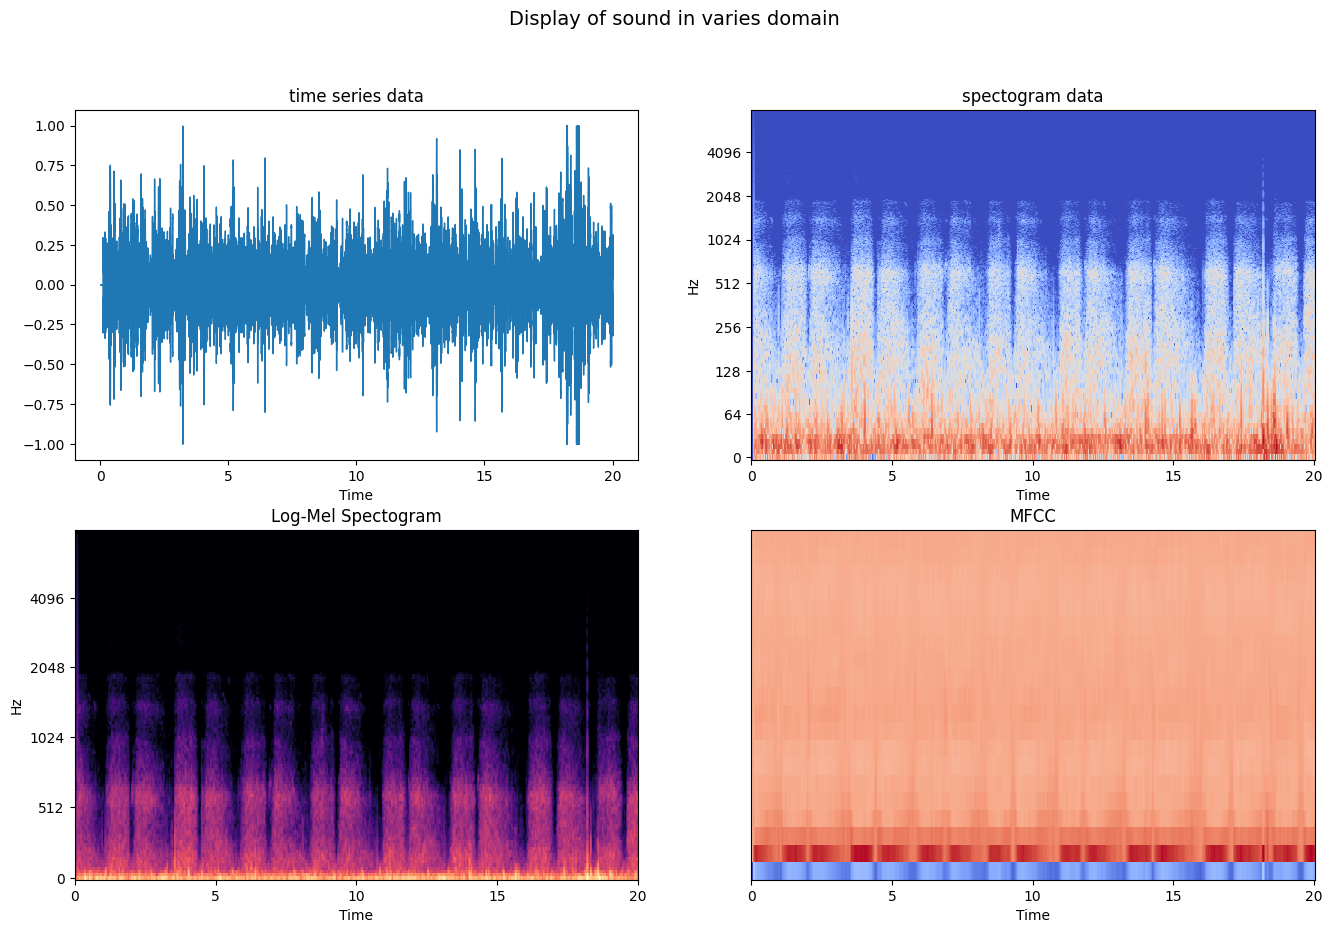

In [18]:
# Displaying sound data 
"""
  time series : amplitude of sound is varied in time domain (1D)
  spectogram : amplitude of sound is varied in time and frequency domain (2D)
"""
# time series data
sr_new = 16000 # resample 16 kHz
x, sr = librosa.load(sound_filename, sr=sr_new) # x : time series data, sr : sample rate

# Spectogram data 
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

# Log-mel spectogram
mel = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8000)
log_mel = librosa.power_to_db(mel, ref=np.max)


# Mel-Frequency Cepstral Coefficient (MFCC)
mfccs = librosa.feature.mfcc(y=x, sr=sr)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

librosa.display.waveshow(y=x, sr=sr, ax=ax[0, 0])
ax[0, 0].set(title='time series data')

librosa.display.specshow(Xdb, x_axis='time',
                         y_axis='log', sr=sr, ax=ax[0, 1])
ax[0, 1].set(title='spectogram data')

librosa.display.specshow(log_mel, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[1, 0])
ax[1, 0].set(title='Log-Mel Spectogram')


librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax[1, 1])
ax[1, 1].set(title='MFCC')

plt.suptitle("Display of sound in varies domain", fontsize=14);


# Preprocessing

In [19]:
def preprocessing(audio_file, mode):
    # we want to resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)

    # padding sound 
    # because duration of sound is dominantly 20 s and all of sample rate is 22050
    # we want to pad or truncated sound which is below or above 20 s respectively
    max_len = 5 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]
    
    if mode == 'mfcc':
      feature = librosa.feature.mfcc(y=x, sr=sr_new)
    
    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)
    

    return feature

In [20]:
# apply preprocessing to sound data

labels = []
labels_3 = []
preprocessed_data = []
for i in tqdm(range(len(file_label_df['filename']))):
  labels.append(file_label_df['Diagnosis'][i])
  #labels_3.append(file_label_df['3 label diagnosis'][i])
  audio_file = audio_path + file_label_df['filename'][i] + '.wav'
  data = preprocessing(audio_file, mode = 'mfcc')
  preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)
labels_3 = np.array(labels_3)



  0%|          | 0/920 [00:00<?, ?it/s]

In [21]:
preprocessed_data[0].shape

(20, 157)

In [22]:
# Reshape data to suit input of model
preprocessed_data = preprocessed_data.reshape((-1, 20, 157, 1))

In [23]:
# one hot encoding labels
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels,num_classes=8) 

#encoder_3 = LabelEncoder()
#i_labels_3 = encoder_3.fit_transform(labels_3)
#oh_labels_3 = to_categorical(i_labels_3) 

In [24]:
oh_labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
type(oh_labels)

numpy.ndarray

In [26]:
print(list(encoder.classes_))

['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']


## Highly Imbalance Dataset ##

In [27]:
unique_values, counts = np.unique(oh_labels, return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.0, Count: 6440
Value: 1.0, Count: 920


In [28]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, oh_labels, 
                                                    test_size=0.2, random_state = 42)

In [29]:
print("size of training set= ",len(x_train))
print("size of testing set= ",len(x_test))

size of training set=  736
size of testing set=  184


In [30]:
oh_labels.shape

(920, 8)

# Training and Testing

## Without miniority class upsampling ##

In [31]:

num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 19, 156, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 9, 78, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 78, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9, 78, 64)      │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 77, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 38, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 38, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4, 38, 64)      │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 37, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,472 (111.22 KB)

 Trainable params: 28,472 (111.22 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [33]:
y_train[1].shape

(8,)

In [34]:
# train model
num_epochs = 300
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.keras',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/300
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3215 - loss: 9.2088       

I0000 00:00:1715272829.438743      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715272829.457279      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.4093 - loss: 8.0151
Epoch 1: val_accuracy improved from -inf to 0.87838, saving model to mymodel2_01.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 814ms/step - accuracy: 0.4299 - loss: 7.7368 - val_accuracy: 0.8784 - val_loss: 1.2358
Epoch 2/300
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8281 - loss: 2.8175
Epoch 2: val_accuracy did not improve from 0.87838
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7759 - loss: 1.8061 - val_accuracy: 0.8784 - val_loss: 0.7939
Epoch 3/300
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8125 - loss: 1.0544
Epoch 3: val_accuracy did not improve from 0.87838
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8463 - loss: 1.0605 - val_accuracy: 0.7973 - val_loss: 0.9420
Epoch 4/300
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8750 - loss: 0.5835
Epoch 4: val_accuracy did not improve from 0.87838
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8600 - loss: 0.7782 - val_

<Figure size 640x480 with 0 Axes>

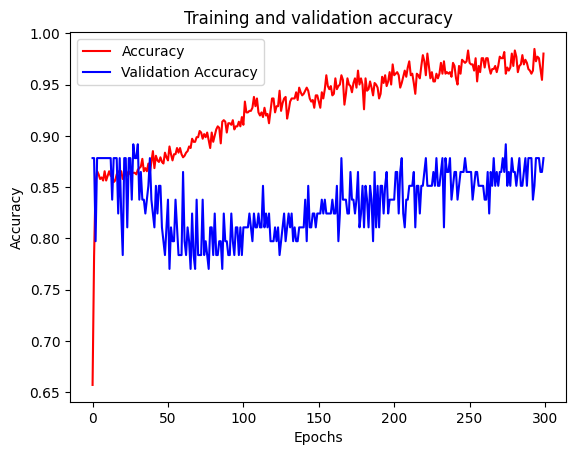

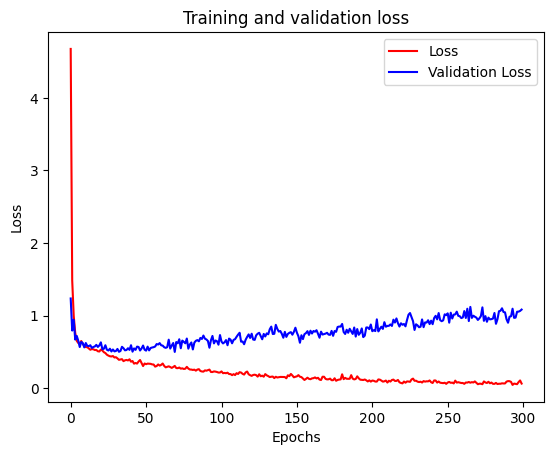

<Figure size 640x480 with 0 Axes>

In [35]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [36]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9551630616188049
Testing Accuracy:  0.8695651888847351


In [37]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=8 # number of classes

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


In [38]:
encoder.classes_

array(['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI'], dtype='<U14')

In [39]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

c_names = ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
       'LRTI', 'Pneumonia', 'URTI']

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


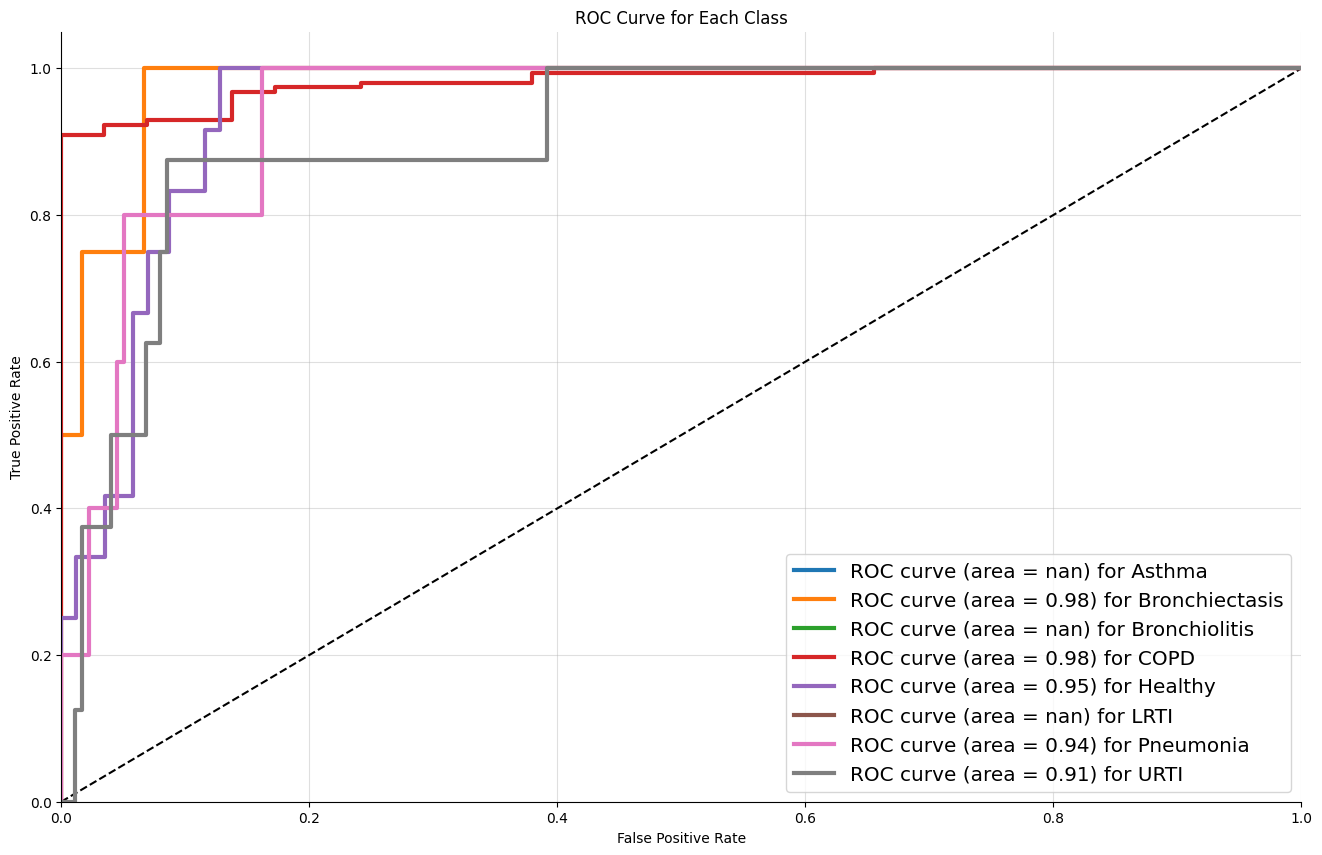

In [40]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [41]:
c_names

['Asthma',
 'Bronchiectasis',
 'Bronchiolitis',
 'COPD',
 'Healthy',
 'LRTI',
 'Pneumonia',
 'URTI']

In [42]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[  2   0   2   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0 152   0   3   0]
 [  0   3   3   2   1   3]
 [  0   0   3   0   2   0]
 [  0   1   2   0   3   2]]


## second approach (fixing class imbalance) ##

In [43]:
preprocessed_data.shape

(920, 20, 157, 1)

In [44]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np



n_samples, height, width, channels = preprocessed_data.shape
X_reshaped = preprocessed_data.reshape(n_samples, -1)

# Instantiate RandomOverSampler
random_oversampler = RandomOverSampler()

# Upsample the minority class using RandomOverSampler
X_resampled, y_resampled = random_oversampler.fit_resample(X_reshaped, oh_labels)
X_restored = X_resampled.reshape(-1, 20, 157, 1)


# Check the shape of the resampled data
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)


Shape of X_resampled: (6344, 3140)
Shape of y_resampled: (6344, 8)


In [45]:
X_restored.shape

(6344, 20, 157, 1)

In [46]:
x_train, x_test, y_train, y_test = train_test_split(X_restored, y_resampled, stratify=y_resampled, 
                                                    test_size=0.2, random_state = 42)

In [47]:
print("size of training set= ",len(x_train))
print("size of testing set= ",len(x_test))

size of training set=  5075
size of testing set=  1269


In [48]:

num_rows = 20
num_columns = 157
num_channels = 1


num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns,num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# train model
num_epochs = 300
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel3_{epoch:02d}.keras',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 19, 156, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 78, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 9, 78, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9, 78, 64)      │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 77, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 38, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 38, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4, 38, 64)      │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 37, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,472 (111.22 KB)

 Trainable params: 28,472 (111.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
24/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1369 - loss: 4.6239

W0000 00:00:1715272886.040739      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.1825 - loss: 3.2976
Epoch 1: val_accuracy improved from -inf to 0.40551, saving model to mymodel3_01.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.1833 - loss: 3.2841 - val_accuracy: 0.4055 - val_loss: 1.6485
Epoch 2/300
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3934 - loss: 1.5936
Epoch 2: val_accuracy improved from 0.40551 to 0.50984, saving model to mymodel3_02.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3968 - loss: 1.5851 - val_accuracy: 0.5098 - val_loss: 1.3040
Epoch 3/300
66/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5498 - loss: 1.3065
Epoch 3: val_accuracy improved from 0.50984 to 0.68898, saving model to mymodel3_03.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5527 - loss: 1.3005 - val_accuracy: 0.6890 - val_loss: 1.0590
Epoch 4/300
67/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6550 - loss: 1.0794
Epoch 4: val_accuracy improved from 0.68898 to 0.71457, 

<Figure size 640x480 with 0 Axes>

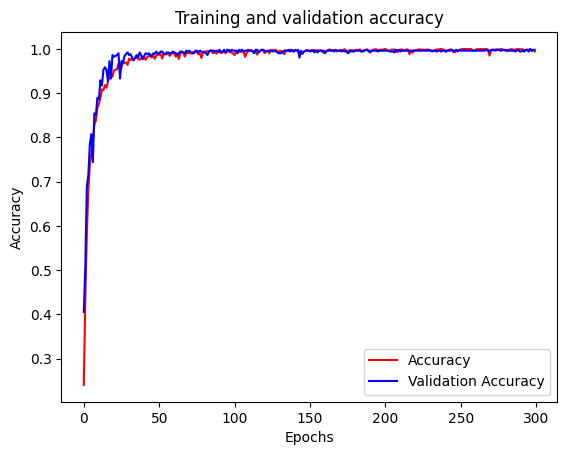

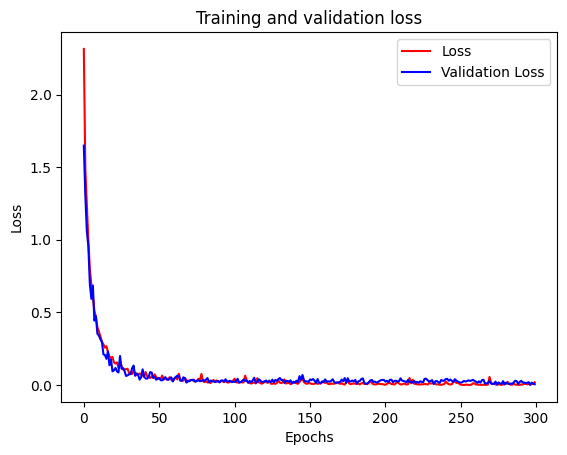

<Figure size 640x480 with 0 Axes>

In [49]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [50]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9996058940887451
Testing Accuracy:  0.996847927570343


In [51]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=8 # number of classes

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [52]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



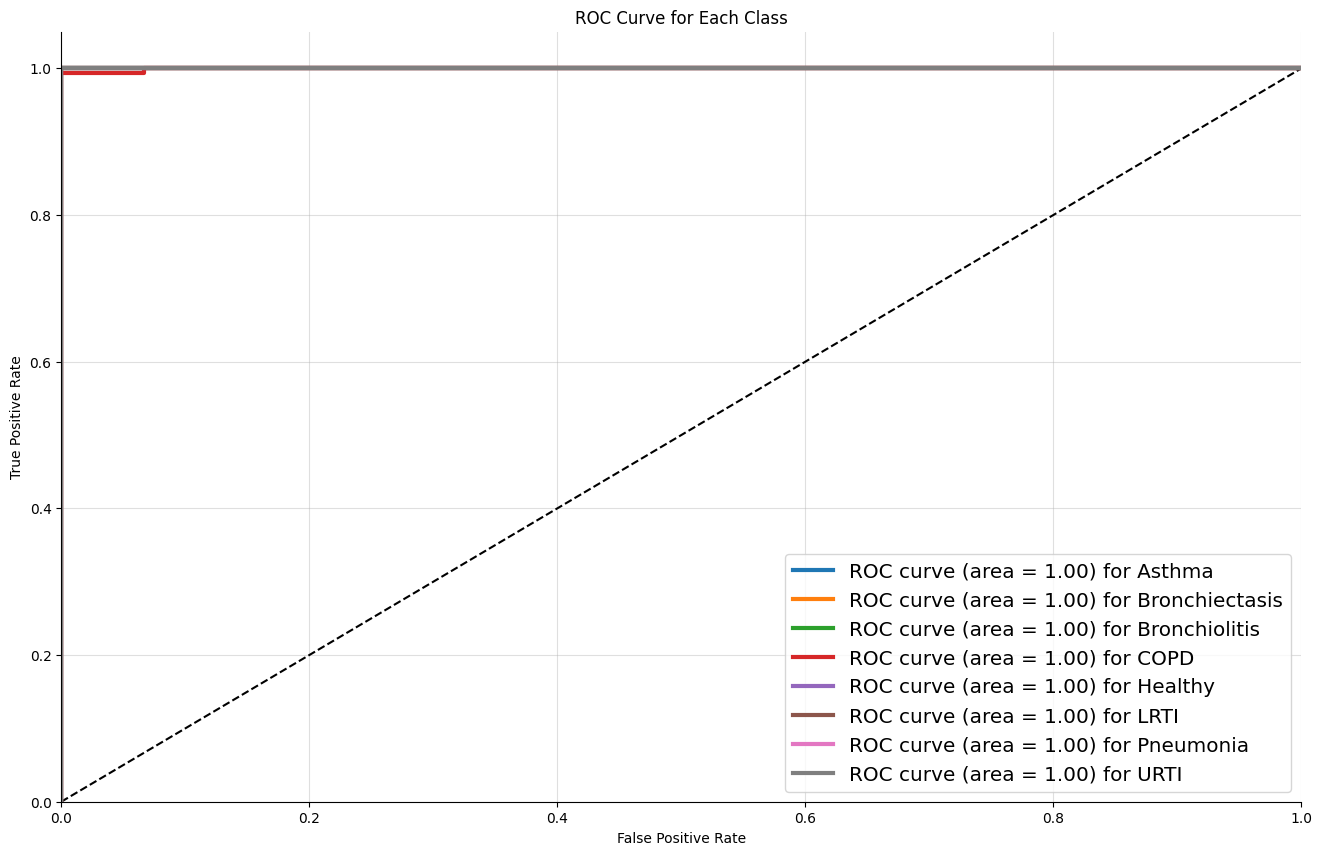

In [53]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [54]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00       159
Bronchiectasis       1.00      1.00      1.00       159
 Bronchiolitis       1.00      1.00      1.00       158
          COPD       1.00      0.97      0.99       159
       Healthy       0.99      1.00      0.99       159
          LRTI       1.00      1.00      1.00       159
     Pneumonia       0.99      1.00      0.99       158
          URTI       1.00      1.00      1.00       158

      accuracy                           1.00      1269
     macro avg       1.00      1.00      1.00      1269
  weighted avg       1.00      1.00      1.00      1269



In [55]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[159   0   0   0   0   0   0   0]
 [  0 159   0   0   0   0   0   0]
 [  0   0 158   0   0   0   0   0]
 [  0   0   0 155   2   0   2   0]
 [  0   0   0   0 159   0   0   0]
 [  0   0   0   0   0 159   0   0]
 [  0   0   0   0   0   0 158   0]
 [  0   0   0   0   0   0   0 158]]


Save model as saved model format

In [56]:
export_dir = 'saved_model/my_model'

tf.saved_model.save(model, export_dir=export_dir)

In [57]:
# saving model in HDF5 format
model.save('prediction_lung_disease_model.keras')